In [2]:
import sys
sys.path.insert(1, '../')
import os
import numpy as np
import mne

kiloword_data_folder = mne.datasets.kiloword.data_path()
kiloword_data_file = os.path.join(kiloword_data_folder,
                                  'kword_metadata-epo.fif')
epochs = mne.read_epochs(kiloword_data_file, verbose=0)

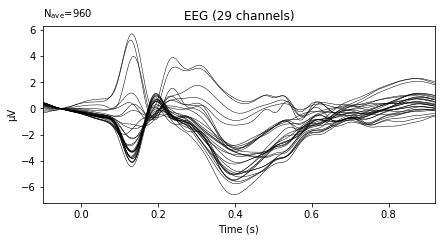

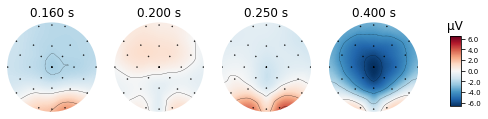

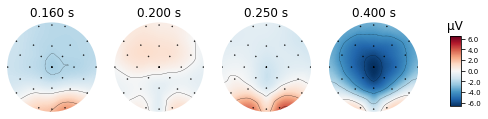

In [3]:
%matplotlib inline
epochs.average().plot()
epochs.average().plot_topomap([0.16, 0.2, 0.25, 0.4])

## Lets prepare the artificial neural network (ANN) for inference!
### Create a forward model
The forward model will be saved in pth_fwd and contains the boundary element method (BEM) solution and source model.

In [5]:
from ESINet.forward import create_forward_model

# Create a forward model
pth_fwd = '../tutorials/forward_models/kword/ico3/'
create_forward_model(pth_fwd, sampling='ico3', info=epochs.info)

Model already exists at path ../tutorials/forward_models/kword/ico3/


## Perform simulations
Artificial neural networks need training data. 
The simulated sources are created by "run_simulations".

The EEG produced by these sources plus some additive noise is created by "create_eeg".

In [6]:
from ESINet.simulations import run_simulations, create_eeg

# Simulate some source and EEG data to train the ANN
sources_sim = run_simulations(pth_fwd, durOfTrial=0, n_simulations=10000)
eeg_sim = create_eeg(sources_sim, pth_fwd, snr=2)

100%|██████████| 10000/10000 [00:00<00:00, 23987.38it/s]



Run 10000 simulations...
has_temporal_dimension:False
return_single_epoch:True

Convert simulations to a single instance of mne.SourceEstimate...

Create EEG trials with noise...

Convert EEG matrices to a single instance of mne.Epochs...
eeg_trials_noisy.shape=(10000, 20, 29, 1)
data.shape=(10000, 29, 1)


## Initialize and train the neural network
The function "get_model" initializes a neural network architecture.

The function "train_model" trains the model with the simulations created in the cell above.

In [ ]:
from ESINet.util import load_leadfield
from ESINet.ann import get_model, train_model, predict

# Initialize and train the neural network
input_dim, output_dim = load_leadfield(pth_fwd).shape
# Initialize the artificial neural network model
model = get_model(input_dim, output_dim)
# Train the model
model, history = train_model(model, sources_sim, eeg_sim)

## ESINet Inverse Solution

In [ ]:
import matplotlib.pyplot as plt
%matplotlib qt
leadfield = load_leadfield(pth_fwd)

# Time point
time_point = 0.31  # 0.24
time_idx = np.argmin(np.abs(epochs.times - time_point))
epochs.set_eeg_reference('average', projection=True)

# Perform inference using the ANN
source_predicted = predict(model, epochs, pth_fwd)

# Plot the predicted sources
title = f'ConvDip Prediction at {time_point}s'
source_predicted.plot(hemi='both', initial_time=time_point, surface='white', title=title, time_viewer=True)


# Plot the Predicted EEG, i.e. the forward solution of the inverse solution
predicted_eeg = np.squeeze(np.matmul(leadfield, source_predicted.data))
plt.figure()
cm, _ = mne.viz.plot_topomap(predicted_eeg[:, time_idx]*1e6, epochs.info)
plt.title(f'Predicted EEG at {time_point}s')
plt.colorbar(cm)

# Plot the actual EEG input scalp map
title = f'Actual EEG at {time_point}s'
epochs.average().plot_topomap(time_point, title=title)


## eLORETA solution
Adapted from https://mne.tools/stable/auto_tutorials/source-modeling/plot_mne_solutions.html#sphx-glr-auto-tutorials-source-modeling-plot-mne-solutions-py

In [ ]:
from ESINet.util import load_fwd
fwd = load_fwd(pth_fwd)
leadfield = load_leadfield(pth_fwd)

# Compute noise covariance matrix
noise_baseline = [-0.1, 0]
noiseCovariance = mne.compute_covariance(epochs, tmin=noise_baseline[0], tmax=noise_baseline[1], method='empirical', verbose=0, n_jobs=-1)
noiseCovariance = mne.cov.regularize(noiseCovariance, epochs.info, rank=None, verbose=0)

snr = 5.0
lambda2 = 1.0 / snr ** 2
epochs.set_eeg_reference('average', projection=True)

# Compute eLORETA inverse operator
inv = mne.minimum_norm.make_inverse_operator(epochs.info, fwd, 
    noiseCovariance, fixed=True, verbose=False)

# Compute eLORETA inverse solution
eloreta_source_estimate = mne.minimum_norm.apply_inverse(epochs.average(), inv, lambda2,
    method='eLORETA', verbose=False )

# Plot eLORETA source
title = f'eLORETA Prediction at {time_point}s'
eloreta_source_estimate.plot(hemi='both', initial_time=time_point, surface='white', colormap='inferno', title=title)

# Plot the Predicted EEG, i.e. the forward solution of the inverse solution
predicted_eeg = np.squeeze(np.matmul(leadfield, eloreta_source_estimate.data))
plt.figure()
cm, _ = mne.viz.plot_topomap(predicted_eeg[:, time_idx]*1e6, epochs.info)
plt.title(f'Predicted EEG eLORETA at {time_point}s')
plt.colorbar(cm)

# Plot the actual EEG input scalp map
title = f'Actual EEG at {time_point}s'
epochs.average().plot_topomap(time_point, title=title)